In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SequentialFeatureSelector

# Modelos
from sklearn.linear_model import LogisticRegression

# Hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Metricas de evaluacion
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

Cargamos el dataset concatenado

In [9]:
df_concat = pd.read_csv("../../data/csv/df_concat_a.csv")

Primero debemos controlar el desbalance de clase, el cual es casi un 92%-8%.

In [4]:
df_concat["target"].value_counts("%")

target
0    0.915759
1    0.084241
Name: proportion, dtype: float64

Balanceo de clases

In [5]:
# Instanciamos el undersample
undersampler = RandomUnderSampler(random_state=16)

# Definimos target y predictoras
X = df_concat.drop(columns=["sk_id_curr", "target"])
y = df_concat["target"]

# Balanceamos las clases
X_balanced, y_balanced = undersampler.fit_resample(X, y)

Realizaremos un forward selection, debido a la no convergencia del modelo en tiempos aceptables.

In [6]:
# Instanciamos un modelo
logistic = LogisticRegression(max_iter=2000)

# Creamos el forward
selector = SequentialFeatureSelector(
    logistic, n_features_to_select=30, scoring="f1")

# Ajustamos el selector
selector.fit(X_balanced, y_balanced)

# Extraemos los index de las features seleccionadas
selected_index = selector.get_support(indices=True)

# Extraemos los nombres de las features seleccionadas
selected_names = X_balanced.columns[selected_index]

# Filtramos el dataset con las features seleccionadas para con buscar mejores hiperparametros.
X_selected = X_balanced[selected_names]

Visualizamos las variables seleccionadas

In [7]:
X_selected.columns

Index(['casa_depto_propio', 'dia_inicio_proceso', 'telefono_trabajo',
       'reg_residencia_diferente', 'reg_trabajo_diferente',
       'tipo_contrato_Cash loans', 'tipo_contrato_Revolving loans',
       'estatus_laboral_Pensioner', 'estatus_laboral_Unemployed',
       'estatus_laboral_Working', 'nivel_educacion_Academic degree',
       'nivel_educacion_Incomplete higher', 'nivel_educacion_Lower secondary',
       'estado_civil_Separated', 'estado_civil_Widow',
       'forma_habitar_Office/Co-op apartment',
       'forma_habitar_Rented apartment', 'ocupacion_Managers',
       'ocupacion_Sales staff', 'tipo_organizacion_trabajo_Armed_forces',
       'tipo_organizacion_trabajo_Construction',
       'tipo_organizacion_trabajo_Finance/Business',
       'tipo_organizacion_trabajo_Industry',
       'tipo_organizacion_trabajo_Medicine', 'tipo_organizacion_trabajo_Other',
       'tipo_organizacion_trabajo_Real Estate',
       'tipo_organizacion_trabajo_Self-employed',
       'tipo_organizacio

Exportamos las features seleccionadas con el forward 30.

In [8]:
X_selected.to_csv("x_selected.csv")

Entrenamos y evaluamos

In [9]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_balanced, test_size=0.2, random_state=42)

# Instanciar un modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000)

# Ajustar el modelo en los datos de entrenamiento
logistic_model.fit(X_train, y_train)

# Predecir las etiquetas en los datos de train
y_pred_train = logistic_model.predict(X_train)

# Predecir las etiquetas en los datos de test
y_pred_test = logistic_model.predict(X_test)


###### ####### ######## #########

print("===============================================================")
# Calcular la matriz de confusión TRAIN
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Matriz de Confusión: TRAIN")
print()
print(conf_matrix_train)
print()
# Imprimir el informe de clasificación TRAIN
report_train = classification_report(y_train, y_pred_train)
print("Informe de Clasificación: TRAIN")
print(report_train)

# Calcular AUC-ROC / AUC-PR TRAIN
roc_train = roc_auc_score(y_train, y_pred_train)
pr_train = average_precision_score(y_train, y_pred_train)

print(f"AUC-ROC para TRAIN : {round(roc_train,3)}")
print(f"AUC-PR para TRAIN : {round(pr_train,3)}")


print("===============================================================")


# Calcular la matriz de confusión TEST
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Matriz de Confusión: TEST")
print()
print(conf_matrix_test)
print()
# Imprimir el informe de clasificación TEST
report_test = classification_report(y_test, y_pred_test)
print("Informe de Clasificación: TEST")
print(report_test)

# Calcular AUC-ROC / AUC-PR TEST
roc_test = roc_auc_score(y_test, y_pred_test)
pr_test = average_precision_score(y_test, y_pred_test)

print(f"AUC-ROC para TEST : {round(roc_test,3)}")
print(f"AUC-PR para TEST : {round(pr_test,3)}")

Matriz de Confusión: TRAIN

[[ 3877  9539]
 [ 2706 10724]]

Informe de Clasificación: TRAIN
              precision    recall  f1-score   support

           0       0.59      0.29      0.39     13416
           1       0.53      0.80      0.64     13430

    accuracy                           0.54     26846
   macro avg       0.56      0.54      0.51     26846
weighted avg       0.56      0.54      0.51     26846

AUC-ROC para TRAIN : 0.544
AUC-PR para TRAIN : 0.523
Matriz de Confusión: TEST

[[ 967 2396]
 [ 698 2651]]

Informe de Clasificación: TEST
              precision    recall  f1-score   support

           0       0.58      0.29      0.38      3363
           1       0.53      0.79      0.63      3349

    accuracy                           0.54      6712
   macro avg       0.55      0.54      0.51      6712
weighted avg       0.55      0.54      0.51      6712

AUC-ROC para TEST : 0.54
AUC-PR para TEST : 0.52


Graficamos AUC ROC y PR para train y test

In [10]:
# Calculamos las tasas de falsos positivos (FPR) y de verdaderos positivos (TPR) para AUC-ROC

fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)

# Calculamos precision y recall para graficar AUC-PR

precision_train, recall_train, _ = precision_recall_curve(
    y_train, y_pred_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_test)

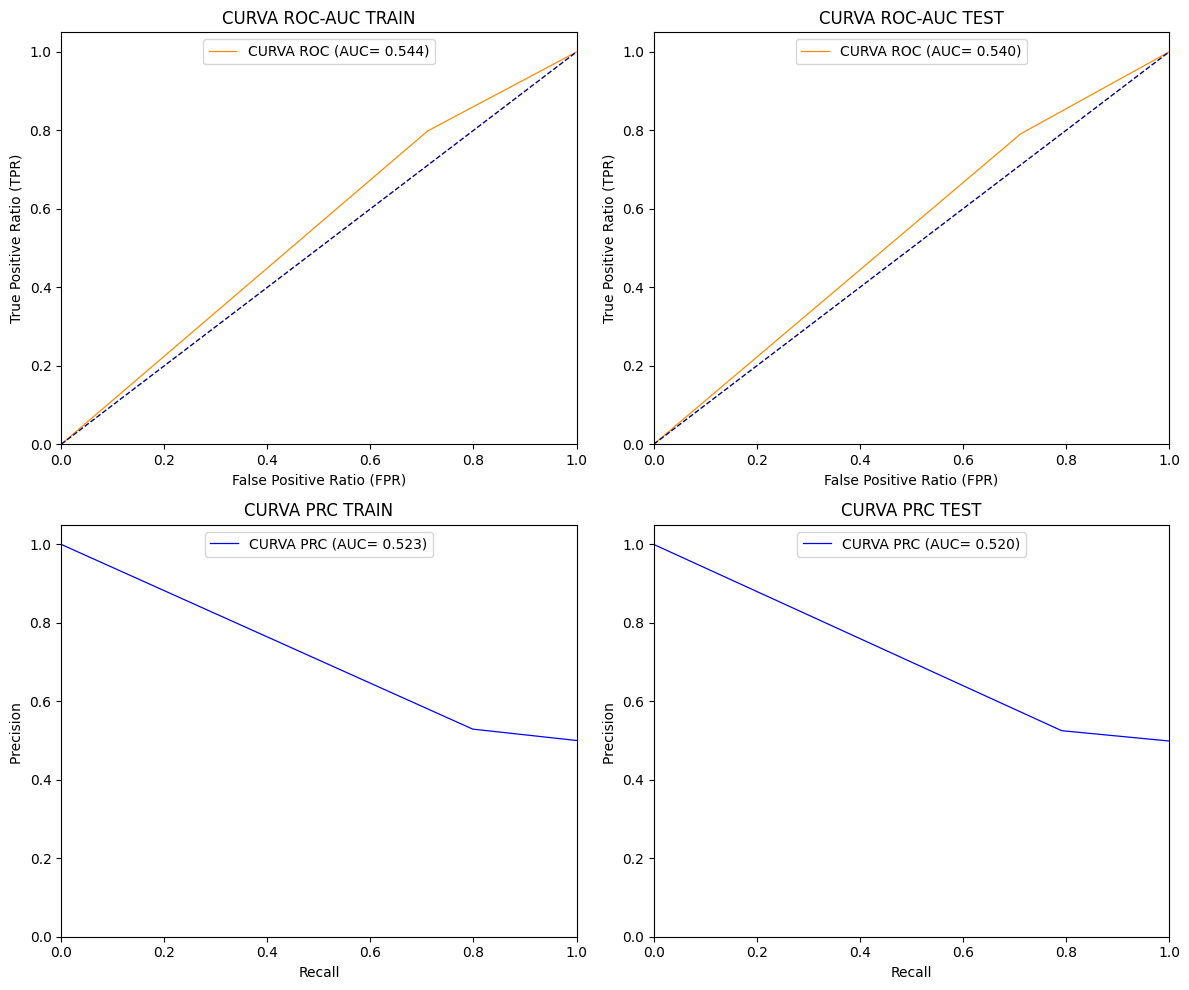

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# AUC-ROC TRAIN
axs[0, 0].plot(fpr_train, tpr_train, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_train)
axs[0, 0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel("False Positive Ratio (FPR)")
axs[0, 0].set_ylabel("True Positive Ratio (TPR)")
axs[0, 0].set_title("CURVA ROC-AUC TRAIN")
axs[0, 0].legend(loc="upper center")

# AUC-ROC TEST
axs[0, 1].plot(fpr_test, tpr_test, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_test)
axs[0, 1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlabel("False Positive Ratio (FPR)")
axs[0, 1].set_ylabel("True Positive Ratio (TPR)")
axs[0, 1].set_title("CURVA ROC-AUC TEST")
axs[0, 1].legend(loc="upper center")

# AUC-PR TRAIN
axs[1, 0].plot(recall_train, precision_train, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_train)
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].set_xlabel("Recall")
axs[1, 0].set_ylabel("Precision ")
axs[1, 0].set_title("CURVA PRC TRAIN")
axs[1, 0].legend(loc="upper center")

# AUC-PR TEST
axs[1, 1].plot(recall_test, precision_test, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_test)
axs[1, 1].set_xlim([0.0, 1.0])
axs[1, 1].set_ylim([0.0, 1.05])
axs[1, 1].set_xlabel("Recall")
axs[1, 1].set_ylabel("Precision ")
axs[1, 1].set_title("CURVA PRC TEST")
axs[1, 1].legend(loc="upper center")

plt.tight_layout()
plt.show()